In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this example, we'll show how CausaDB can be used to optimise yield on a production line. Yield measures the proportion of good units produced by a process. It is a key performance indicator in manufacturing, and is often used to measure the effectiveness of a production line.

Machine configuration and settings can have a significant impact on yield. In this example, we'll use CausaDB to optimise the settings of multiple machines in a production line to maximise yield.

## Load dependencies and configure client

First, we'll load the necessary dependencies and configure the CausaDB client.

In [61]:
from causadb import CausaDB
from causadb.plotting import plot_causal_graph, plot_causal_attributions
import numpy as np
import pandas as pd
import os
import json

client = CausaDB(token=os.environ.get('CAUSADB_TOKEN'))

## Load in data and attach to CausaDB

We've generated some example data for a production line with multiple stages and some interdependencies between the machines. We'll load this data into CausaDB and attach it to the client.

In [62]:
data = pd.read_csv('production_data.csv')
data.head()

,Input_A,Input_B,Input_C,Config_A1,Config_B1,Config_B2,Config_C1,Config_C2,Yield_A1,Config_A2,Yield_B1,Config_B3,Yield_A2,Config_A3,Yield_B2,Yield_C1,Yield_A3,Yield_B3,Yield_C2,Output
0,62.21,91.48,72.55,0.34,0.42,0.39,0.52,0.87,0.64,0.54,0.52,0.51,0.62,0.62,0.53,0.38,0.60,0.63,0.68,0.88
1,74.00,124.91,75.04,0.65,0.34,0.35,0.27,0.63,0.54,0.74,0.47,0.54,0.73,0.69,0.45,0.20,0.75,0.57,0.41,0.85
2,121.30,121.10,87.57,0.51,0.59,0.62,0.32,0.44,0.69,0.49,0.60,0.64,0.59,0.69,0.77,0.38,0.65,0.78,0.35,0.85
3,116.46,115.30,94.24,0.84,0.36,0.70,0.36,0.66,0.56,0.76,0.50,0.85,0.70,0.77,0.68,0.35,0.80,0.88,0.46,0.95
4,67.43,145.29,94.29,0.68,0.39,0.59,0.49,0.70,0.44,0.81,0.53,0.67,0.65,0.94,0.63,0.49,0.82,0.84,0.66,0.99


In [63]:
client \
  .add_data("example-production-data") \
  .from_pandas(data)

## Load nodes and edges and train model

There are many nodes and edges in this example, so we'll load them in from a file and then define and train a model on the data.

In [64]:
# Load nodes and edges from json files
with open('nodes.json', 'r') as f:
    nodes = json.load(f)

with open('edges.json', 'r') as f:
    edges = json.load(f)

In [65]:
model = client.create_model("example-production-model")
model.set_nodes(nodes)
model.set_edges(edges)

model.train("example-production-data")

## Plot the graph

In this example, the causal graph is best represented as a flowchart, so we'll use the `style='flowchart'` option in the `plot_causal_graph` function.

In [66]:
plot_causal_graph(model, style="flowchart", theme="dark", direction="LR")

## Find optimal machine configurations to maximise yield

Since configuration settings are modifiable, we can take action on them. We can use the `find_best_actions` function to find the combination of configuration settings that will maximise yield.

In [67]:
optimal_config = model.find_best_actions(
    targets={"Output": "maximise"},
    actionable=["Config_A1", "Config_A2", "Config_A3", "Config_B1", "Config_B2", "Config_B3", "Config_C1", "Config_C2"],
)

optimal_config.round(2)

,Config_A1,Config_A2,Config_A3,Config_B1,Config_B2,Config_B3,Config_C1,Config_C2
0,0.61,0.88,0.96,0.48,0.5,0.54,0.57,0.58


This set of configuration settings can then be applied to the machines in the production line to maximise yield. More precise control could be achieved by also setting some of the variable inputs to the process using `fixed` in the `find_best_actions` function, but we'll keep it simple for this example.

In addition, we can also model trade-offs between different objectives. For example, we could find the configuration settings that maximise yield while minimising byproduct production by setting multiple targets. Multiple targets can also be weighted to reflect the relative importance of each objective using the `target_importance` parameter.

## Explain the causes of yield

Unlike standard AI models, causal models can explain the true causes of an outcome. We can use the `causal_attributions` function to find the causes of yield and their relative magnitudes.

<Axes: title={'center': 'Causal attribution of Output'}, xlabel='Causal attribution', ylabel='Node'>

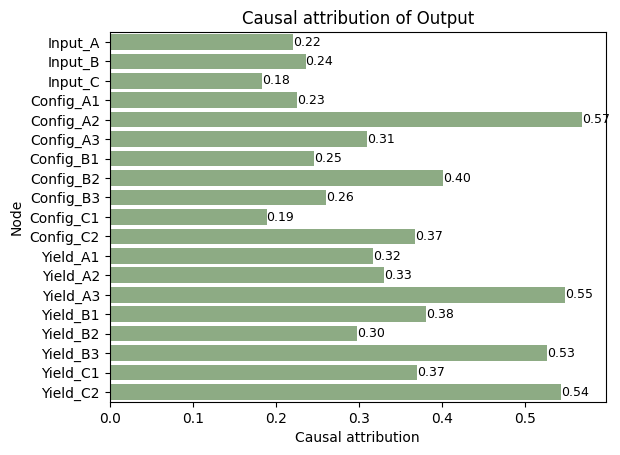

In [68]:
plot_causal_attributions(model, "Output")

Standard AI models usually attribute causality to the factors nearest to the outcome variable, but this can be highly misleading when applied to systems such as production lines where there are long chains of causality as machines feed their outputs into each other sequentially. Causal models are the only way to accurately attribute causality and make correct optimisation decisions.

## Summary

In this example, we've shown how CausaDB can be used to optimise yield on a production line. By modelling the causal relationships between machines and their settings, we can find the optimal configuration settings to maximise yield. We can also use the causal model to explain the causes of yield and their relative magnitudes.